In [87]:
import pandas as pd

# Lista dei percorsi dei file CSV
file_paths = [
    'data/tilt_data/ECP/ETNA_ECP_2021_1MINUTO.csv',
    'data/tilt_data/CBD/ETNA_CBD_2021_1MINUTO.csv',
    'data/tilt_data/PDN/ETNA_PDN_2021_1MINUTO.csv',
    'data/tilt_data/PLC/ETNA_PLC_2021_1MINUTO.csv'
]

# Itera su ciascun file path nella lista
for file_path in file_paths:
    print(f"Analisi del file: {file_path}")
    
    # Carica solo le prime righe del file per vedere l'intestazione
    df = pd.read_csv(file_path, nrows=5)
    print("Intestazioni delle colonne:")
    print(df.columns)
    print("-" * 40)
    
for file_path in file_paths:
    print(f"Analisi del file: {file_path}")
    
    # Caricamento del file CSV
    df = pd.read_csv(file_path)
    
    # Visualizza le prime righe del file per controllare i dati
    print(df.head())
    
    # Conta i valori mancanti in ogni colonna
    missing_values = df.isnull().sum()
    
    # Stampa il conteggio dei valori mancanti
    print("Valori mancanti per colonna:")
    print(missing_values)
    print("-" * 40)  # Separatore tra i risultati dei file

Analisi del file: data/tilt_data/ECP/ETNA_ECP_2021_1MINUTO.csv
Intestazioni delle colonne:
Index(['TIMESTAMP;tilt_x_Avg;tilt_y_Avg;temp_tilt_Avg'], dtype='object')
----------------------------------------
Analisi del file: data/tilt_data/CBD/ETNA_CBD_2021_1MINUTO.csv
Intestazioni delle colonne:
Index(['TIMESTAMP;TILTX_Avg;TILTY_Avg;TEMPERATURA_Avg'], dtype='object')
----------------------------------------
Analisi del file: data/tilt_data/PDN/ETNA_PDN_2021_1MINUTO.csv
Intestazioni delle colonne:
Index(['TIMESTAMP;tilt_x_Avg;tilt_y_Avg;temp_tilt_Avg'], dtype='object')
----------------------------------------
Analisi del file: data/tilt_data/PLC/ETNA_PLC_2021_1MINUTO.csv
Intestazioni delle colonne:
Index(['TIMESTAMP;tilt_x_Avg;tilt_y_Avg;temp_tilt_Avg'], dtype='object')
----------------------------------------
Analisi del file: data/tilt_data/ECP/ETNA_ECP_2021_1MINUTO.csv
  TIMESTAMP;tilt_x_Avg;tilt_y_Avg;temp_tilt_Avg
0    01/01/2021 00:00;-45.56833;-51.77447;4.745
1    01/01/2021 00:01

In [116]:
import pandas as pd

# Definizione dei percorsi dei file CSV
file_paths = {
    'ECP': 'data/tilt_data/ECP/ETNA_ECP_2021_1MINUTO.csv',
    'CBD': 'data/tilt_data/CBD/ETNA_CBD_2021_1MINUTO.csv',
    'PDN': 'data/tilt_data/PDN/ETNA_PDN_2021_1MINUTO.csv',
    'PLC': 'data/tilt_data/PLC/ETNA_PLC_2021_1MINUTO.csv'
}

# Dizionario per memorizzare i DataFrame caricati
dataframes = {}

# Caricamento e uniformazione del timestamp di ciascun file
for station, file_path in file_paths.items():
    # Carica il file
    try:
        df = pd.read_csv(file_path, delimiter=';', engine='python')
    except Exception as e:
        df = pd.read_csv(file_path, delimiter=',', engine='python')

    # Converti il timestamp in formato datetime
    if station == 'CBD':
        # Per CBD usa il formato 'YYYY-MM-DD HH:MM'
        df['timestamp'] = pd.to_datetime(df['TIMESTAMP'], format='%Y-%m-%d %H:%M', errors='coerce')
        # Rimuovi le colonne 'station', 'temp_tilt_Avg', e 'TEMPERATURA_Avg' se esistono
        if 'temp_tilt_Avg' in df.columns:
            df.drop(columns=['temp_tilt_Avg'], inplace=True)
        if 'station' in df.columns:
            df.drop(columns=['station'], inplace=True)
        if 'TEMPERATURA_Avg' in df.columns:
            df.drop(columns=['TEMPERATURA_Avg'], inplace=True)
    else:
        # Per gli altri usa il formato 'DD/MM/YYYY HH:MM'
        df['timestamp'] = pd.to_datetime(df['TIMESTAMP'], format='%d/%m/%Y %H:%M', errors='coerce')
        # Rimuovi la colonna 'station'
        if 'station' in df.columns:
            df.drop(columns=['station'], inplace=True)

    # Rimuovi la colonna originale del timestamp
    df.drop(columns=['TIMESTAMP'], inplace=True)

    # Rimuovi la colonna ridondante 'temp_tilt_Avg' se esiste
    if 'temp_tilt_Avg' in df.columns:
        df.drop(columns=['temp_tilt_Avg'], inplace=True)

    # Conta e stampa il numero di righe con timestamp non valido
    invalid_timestamps = df['timestamp'].isna().sum()
    print(f"Stazione {station}: {invalid_timestamps} righe con timestamp non valido saranno rimosse.")

    # Rimuovi eventuali righe con timestamp non valido
    df = df.dropna(subset=['timestamp'])

    # Ordina i dati per timestamp
    df = df.sort_values(by='timestamp')

    # Controllo per identificare buchi nei timestamp (frequenza 1 minuto)
    full_range = pd.date_range(start=df['timestamp'].min(), end=df['timestamp'].max(), freq='1min')
    missing_timestamps = full_range.difference(df['timestamp'])
    if not missing_timestamps.empty:
        print(f"Stazione {station}: trovati {len(missing_timestamps)} buchi nei timestamp.")
        print(missing_timestamps)
        # Aggiungi righe con timestamp mancanti e valori nulli
        missing_df = pd.DataFrame(index=missing_timestamps, columns=df.columns)
        df = pd.concat([df.set_index('timestamp'), missing_df], axis=0, sort=False).sort_index()
    else:
        print(f"Stazione {station}: nessun buco nei timestamp.")

    # Rimuovi l'ultima colonna se è ridondante
    if df.columns[-1] == 'timestamp':
        df.drop(columns=['timestamp'], inplace=True)

    # Imposta il timestamp come indice
    df.index.name = 'timestamp'

    # Salva il DataFrame in un file CSV
    output_path = f'data/tilt_data/v2/{station}_timestamp_fixed.csv'
    df.to_csv(output_path)

    # Aggiungi il DataFrame al dizionario per uso futuro (opzionale)
    dataframes[station] = df

print("I file delle stazioni sono stati salvati correttamente in formato CSV.")


Stazione ECP: 0 righe con timestamp non valido saranno rimosse.
Stazione ECP: trovati 60 buchi nei timestamp.
DatetimeIndex(['2021-10-31 00:00:00', '2021-10-31 00:01:00',
               '2021-10-31 00:02:00', '2021-10-31 00:03:00',
               '2021-10-31 00:04:00', '2021-10-31 00:05:00',
               '2021-10-31 00:06:00', '2021-10-31 00:07:00',
               '2021-10-31 00:08:00', '2021-10-31 00:09:00',
               '2021-10-31 00:10:00', '2021-10-31 00:11:00',
               '2021-10-31 00:12:00', '2021-10-31 00:13:00',
               '2021-10-31 00:14:00', '2021-10-31 00:15:00',
               '2021-10-31 00:16:00', '2021-10-31 00:17:00',
               '2021-10-31 00:18:00', '2021-10-31 00:19:00',
               '2021-10-31 00:20:00', '2021-10-31 00:21:00',
               '2021-10-31 00:22:00', '2021-10-31 00:23:00',
               '2021-10-31 00:24:00', '2021-10-31 00:25:00',
               '2021-10-31 00:26:00', '2021-10-31 00:27:00',
               '2021-10-31 00:28:00'

C:\Users\giuli\AppData\Local\Temp\ipykernel_44708\1980942372.py:65: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df.set_index('timestamp'), missing_df], axis=0, sort=False).sort_index()


Stazione CBD: 0 righe con timestamp non valido saranno rimosse.
Stazione CBD: trovati 13324 buchi nei timestamp.
DatetimeIndex(['2021-10-27 05:59:00', '2021-10-27 06:00:00',
               '2021-10-27 06:01:00', '2021-10-27 06:02:00',
               '2021-10-27 06:03:00', '2021-10-27 06:04:00',
               '2021-10-27 06:05:00', '2021-10-27 06:06:00',
               '2021-10-27 06:07:00', '2021-10-27 06:08:00',
               ...
               '2021-11-18 23:17:00', '2021-11-18 23:18:00',
               '2021-11-18 23:19:00', '2021-11-18 23:20:00',
               '2021-11-18 23:22:00', '2021-11-18 23:24:00',
               '2021-11-18 23:25:00', '2021-11-18 23:26:00',
               '2021-11-18 23:27:00', '2021-11-18 23:28:00'],
              dtype='datetime64[ns]', length=13324, freq=None)


C:\Users\giuli\AppData\Local\Temp\ipykernel_44708\1980942372.py:65: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df.set_index('timestamp'), missing_df], axis=0, sort=False).sort_index()


Stazione PDN: 0 righe con timestamp non valido saranno rimosse.
Stazione PDN: trovati 60 buchi nei timestamp.
DatetimeIndex(['2021-10-31 00:00:00', '2021-10-31 00:01:00',
               '2021-10-31 00:02:00', '2021-10-31 00:03:00',
               '2021-10-31 00:04:00', '2021-10-31 00:05:00',
               '2021-10-31 00:06:00', '2021-10-31 00:07:00',
               '2021-10-31 00:08:00', '2021-10-31 00:09:00',
               '2021-10-31 00:10:00', '2021-10-31 00:11:00',
               '2021-10-31 00:12:00', '2021-10-31 00:13:00',
               '2021-10-31 00:14:00', '2021-10-31 00:15:00',
               '2021-10-31 00:16:00', '2021-10-31 00:17:00',
               '2021-10-31 00:18:00', '2021-10-31 00:19:00',
               '2021-10-31 00:20:00', '2021-10-31 00:21:00',
               '2021-10-31 00:22:00', '2021-10-31 00:23:00',
               '2021-10-31 00:24:00', '2021-10-31 00:25:00',
               '2021-10-31 00:26:00', '2021-10-31 00:27:00',
               '2021-10-31 00:28:00'

C:\Users\giuli\AppData\Local\Temp\ipykernel_44708\1980942372.py:65: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df.set_index('timestamp'), missing_df], axis=0, sort=False).sort_index()


Stazione PLC: 0 righe con timestamp non valido saranno rimosse.
Stazione PLC: trovati 60 buchi nei timestamp.
DatetimeIndex(['2021-10-31 00:00:00', '2021-10-31 00:01:00',
               '2021-10-31 00:02:00', '2021-10-31 00:03:00',
               '2021-10-31 00:04:00', '2021-10-31 00:05:00',
               '2021-10-31 00:06:00', '2021-10-31 00:07:00',
               '2021-10-31 00:08:00', '2021-10-31 00:09:00',
               '2021-10-31 00:10:00', '2021-10-31 00:11:00',
               '2021-10-31 00:12:00', '2021-10-31 00:13:00',
               '2021-10-31 00:14:00', '2021-10-31 00:15:00',
               '2021-10-31 00:16:00', '2021-10-31 00:17:00',
               '2021-10-31 00:18:00', '2021-10-31 00:19:00',
               '2021-10-31 00:20:00', '2021-10-31 00:21:00',
               '2021-10-31 00:22:00', '2021-10-31 00:23:00',
               '2021-10-31 00:24:00', '2021-10-31 00:25:00',
               '2021-10-31 00:26:00', '2021-10-31 00:27:00',
               '2021-10-31 00:28:00'

C:\Users\giuli\AppData\Local\Temp\ipykernel_44708\1980942372.py:65: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df.set_index('timestamp'), missing_df], axis=0, sort=False).sort_index()


I file delle stazioni sono stati salvati correttamente in formato CSV.


In [119]:
import pandas as pd

# Definizione dei percorsi dei file CSV da analizzare
file_paths = {
    'ECP': 'data/tilt_data/v2/ECP_timestamp_fixed.csv',
    'CBD': 'data/tilt_data/v2/CBD_timestamp_fixed.csv',
    'PDN': 'data/tilt_data/v2/PDN_timestamp_fixed.csv',
    'PLC': 'data/tilt_data/v2/PLC_timestamp_fixed.csv'
}

# Lista per memorizzare i buchi di valori
gaps = []

# Analisi dei valori mancanti nei file CSV aggiornati
for station, file_path in file_paths.items():
    # Carica il file
    df = pd.read_csv(file_path)

    # Converti il timestamp in formato datetime e imposta come indice
    df['timestamp'] = pd.to_datetime(df['timestamp'], errors='coerce')
    df.set_index('timestamp', inplace=True)

    # Trova i valori mancanti e registra i periodi di buchi
    missing_values = df[df.isna().any(axis=1)]
    if not missing_values.empty:
        gap_start = None
        for idx in missing_values.index:
            if gap_start is None:
                gap_start = idx
            if gap_start is not None and (idx + pd.Timedelta(minutes=1)) not in missing_values.index:
                gap_end = idx
                gap_duration = (gap_end - gap_start) / pd.Timedelta(minutes=1)
                if gap_duration <= 10:
                    # Interpolazione dei gap inferiori o uguali a 15 minuti
                    df.loc[gap_start:gap_end] = df.loc[gap_start:gap_end].interpolate(method='time')
                else:
                    # Registra il gap per quelli superiori a 15 minuti
                    gaps.append({'station': station, 'gap_start': gap_start, 'gap_end': gap_end})
                gap_start = None

# Crea un DataFrame con tutti i buchi di valori rimasti
gaps_df = pd.DataFrame(gaps)

# Salva il DataFrame in un file CSV
output_path = 'data/tilt_data/v2/missing_values_gaps_summary.csv'
gaps_df.to_csv(output_path, index=False)

# Salva i file CSV aggiornati con i gap interpolati
for station, file_path in file_paths.items():
    df = pd.read_csv(file_path)
    output_path = f'data/tilt_data/v2/{station}_interpolated.csv'
    df.to_csv(output_path, index=False)

print("I buchi di valori sono stati interpolati (dove possibile) e i file aggiornati sono stati salvati.")

I buchi di valori sono stati interpolati (dove possibile) e i file aggiornati sono stati salvati.


In [121]:
import pandas as pd

# Carica i file PKL e CSV
pkl_path = 'data/tilt_data/Fixed_timestamp_ECBD.pkl'
csv_path = 'data/tilt_data/v2/CBD_interpolated.csv'

df_pkl = pd.read_pickle(pkl_path)
df_csv = pd.read_csv(csv_path)

# Converte i timestamp in datetime
df_pkl.index = pd.to_datetime(df_pkl.index, errors='coerce')
df_csv['timestamp'] = pd.to_datetime(df_csv['timestamp'], errors='coerce')

# Filtra per il 1 gennaio 2021 e ottieni le prime 10 righe
df_pkl_2021_01_01 = df_pkl[(df_pkl.index >= '2021-01-01') & (df_pkl.index < '2021-01-02')].head(10)
df_csv_2021_01_01 = df_csv[df_csv['timestamp'].dt.date == pd.Timestamp('2021-01-01').date()].head(10)

print("Prime 10 righe del 1 gennaio 2021 - File PKL (UTC):")
print(df_pkl_2021_01_01)

print("\nPrime 10 righe del 1 gennaio 2021 - File CSV:")
print(df_csv_2021_01_01)



Prime 10 righe del 1 gennaio 2021 - File PKL (UTC):
                     TILTX_Avg  TILTY_Avg  TEMPERATURA_Avg
TIMESTAMP                                                 
2021-01-01 00:00:00   94.02685   240.9929            6.889
2021-01-01 00:01:00   94.02763   240.9790            6.888
2021-01-01 00:02:00   94.00105   240.9787            6.888
2021-01-01 00:03:00   94.02243   240.9921            6.890
2021-01-01 00:04:00   94.00603   240.9790            6.888
2021-01-01 00:05:00   94.02446   240.9864            6.888
2021-01-01 00:06:00   94.00700   240.9848            6.890
2021-01-01 00:07:00   94.00691   240.9791            6.893
2021-01-01 00:08:00   94.00838   240.9634            6.891
2021-01-01 00:09:00   94.01136   240.9885            6.891

Prime 10 righe del 1 gennaio 2021 - File CSV:
            timestamp  TILTX_Avg  TILTY_Avg
0 2021-01-01 00:00:00   94.02685   240.9929
1 2021-01-01 00:01:00   94.02763   240.9790
2 2021-01-01 00:02:00   94.00105   240.9787
3 2021-01-01 00:0

In [22]:
import pandas as pd
import numpy as np
from geopy.distance import geodesic

# Definizione dei percorsi dei file CSV da analizzare
file_paths = {
    'ECP': 'data/tilt_data/v2/ECP_interpolated.csv',
    'CBD': 'data/tilt_data/v2/CBD_interpolated.csv',
    'PDN': 'data/tilt_data/v2/PDN_interpolated.csv',
    'PLC': 'data/tilt_data/v2/PLC_interpolated.csv'
}

# Coordinate delle stazioni
station_coords = {
    'PLC': (37.765, 14.985),
    'PDN': (37.765, 15.016),
    'CBD': (37.78, 15.086),
    'ECP': (37.743, 14.986)
}

# Funzione per calcolare la distanza tra due stazioni
def calculate_distance(coord1, coord2):
    return geodesic(coord1, coord2).kilometers

# Calcola la matrice delle distanze tra le stazioni
distance_matrix = pd.DataFrame(index=station_coords.keys(), columns=station_coords.keys(), dtype=float)
for station1 in station_coords.keys():
    for station2 in station_coords.keys():
        if station1 != station2:
            distance_matrix.loc[station1, station2] = calculate_distance(station_coords[station1], station_coords[station2])
        else:
            distance_matrix.loc[station1, station2] = 0.0

# Caricamento dei dati delle stazioni
dataframes = {}
for station, file_path in file_paths.items():
    df = pd.read_csv(file_path)
    df['timestamp'] = pd.to_datetime(df['timestamp'], errors='coerce')
    df.set_index('timestamp', inplace=True)
    df.replace(['', ' '], np.nan, inplace=True)  # Sostituisci valori vuoti o spazi con NaN

    # Rimuovi i dati per la stazione CBD nel range specificato
    if station == 'CBD':
        df = df.drop(df.loc['2021-10-27 05:58':'2021-11-02 03:05'].index)

    dataframes[station] = df

# Imputazione dei gap mancanti basata sui cambiamenti delta
for station, df in dataframes.items():
    missing_values = df[df.isna().any(axis=1)]
    if not missing_values.empty:
        for timestamp in missing_values.index:
            # Trova l'ultimo valore disponibile prima del gap
            previous_timestamp = df[:timestamp].last_valid_index()
            if previous_timestamp is not None:
                previous_values = df.loc[previous_timestamp]

                # Trova le stazioni che hanno valori disponibili per quel timestamp
                delta_x_list = []
                delta_y_list = []
                distances = []
                for other_station, other_df in dataframes.items():
                    if other_station != station and timestamp in other_df.index and previous_timestamp in other_df.index:
                        delta_x = other_df.loc[timestamp, 'tilt_x_Avg'] - other_df.loc[previous_timestamp, 'tilt_x_Avg']
                        delta_y = other_df.loc[timestamp, 'tilt_y_Avg'] - other_df.loc[previous_timestamp, 'tilt_y_Avg']

                        # Controlla se i valori non sono NaN e sono scalari
                        if np.isscalar(delta_x) and np.isscalar(delta_y) and pd.notna(delta_x) and pd.notna(delta_y):
                            delta_x_list.append(delta_x)
                            delta_y_list.append(delta_y)
                            distances.append(distance_matrix.loc[station, other_station])

                # Se ci sono stazioni disponibili, calcola la media ponderata dei delta
                if len(delta_x_list) > 0 and len(delta_y_list) > 0:
                    weights = np.array([1 / d if d != 0 else 1 for d in distances])
                    total_weight = np.sum(weights)

                    if total_weight != 0:  # Evita la divisione per zero
                        weighted_delta_x = np.dot(delta_x_list, weights) / total_weight
                        weighted_delta_y = np.dot(delta_y_list, weights) / total_weight

                        # Assegna i valori imputati sommando il delta ponderato all'ultimo valore disponibile
                        if pd.isna(df.at[timestamp, 'tilt_x_Avg']):
                            df.at[timestamp, 'tilt_x_Avg'] = round(previous_values['tilt_x_Avg'] + weighted_delta_x, 5)
                        if pd.isna(df.at[timestamp, 'tilt_y_Avg']):
                            df.at[timestamp, 'tilt_y_Avg'] = round(previous_values['tilt_y_Avg'] + weighted_delta_y, 5)

# Salva i file CSV aggiornati con i gap imputati
for station, df in dataframes.items():
    output_path = f'data/tilt_data/v2/{station}_imputed.csv'
    df.to_csv(output_path)

print("I gap mancanti sono stati imputati utilizzando la variazione media ponderata delle altre stazioni e i file aggiornati sono stati salvati.")


I gap mancanti sono stati imputati utilizzando la variazione media ponderata delle altre stazioni e i file aggiornati sono stati salvati.


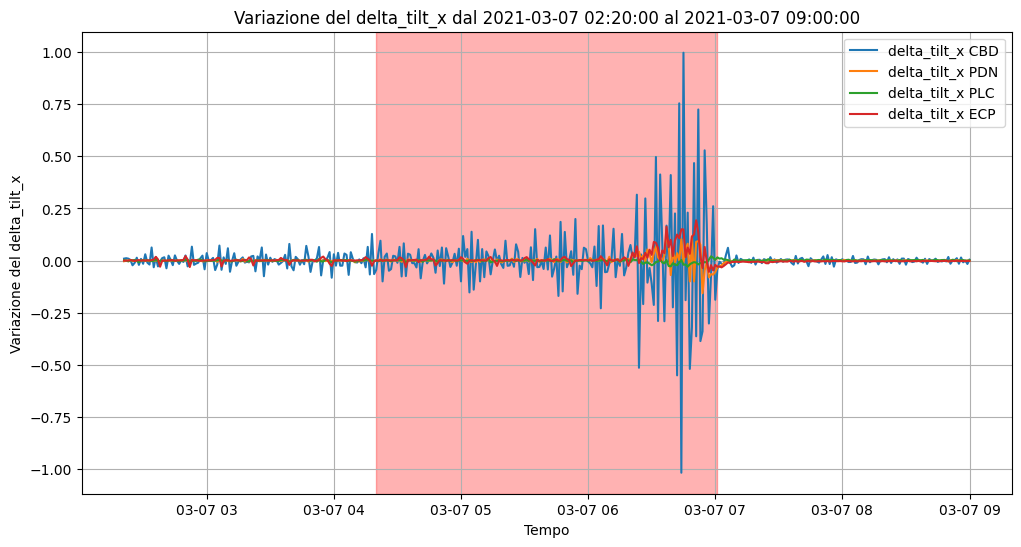

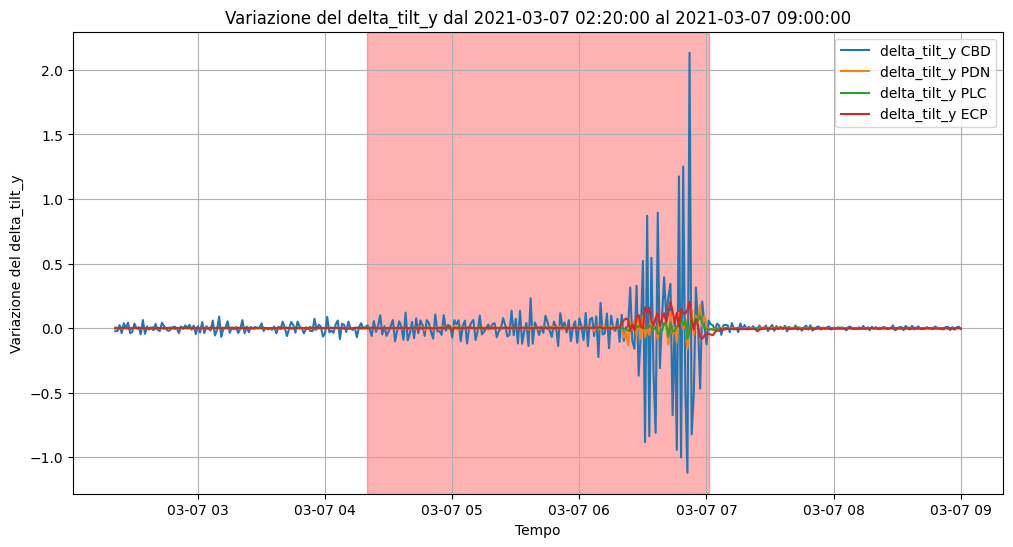

In [37]:
import pandas as pd
import matplotlib.pyplot as plt

# Caricamento dei file tilt dalle stazioni per la visualizzazione dei dati
tilt_stations = ['CBD', 'PDN', 'PLC', 'ECP']
tilt_data = pd.DataFrame()

for station in tilt_stations:
    tilt_file_path = f'data/tilt_data/v2/{station}_imputed.csv'
    station_tilt_data = pd.read_csv(tilt_file_path)
    station_tilt_data['timestamp'] = pd.to_datetime(station_tilt_data['timestamp'], errors='coerce')
    station_tilt_data.set_index('timestamp', inplace=True)
    station_tilt_data['Station'] = station
    tilt_data = pd.concat([tilt_data, station_tilt_data])

# Carica il dataset degli eventi vulcanici
events_file_path = 'Data/csv_eruzioni/volcanic_events_numeric_controlled.csv'
events_data = pd.read_csv(events_file_path)

# Converti le colonne di tempo degli eventi in formato datetime
events_data['Starting Time'] = pd.to_datetime(events_data['Starting Time']).dt.tz_localize(None)
events_data['Ending Time'] = pd.to_datetime(events_data['Ending Time']).dt.tz_localize(None)

# Specifica l'intervallo temporale
start_date = pd.to_datetime('2021-3-7 2:20:00').tz_localize(None)
end_date = pd.to_datetime('2021-3-7 9:00:00').tz_localize(None)

# Filtra i dati in base all'intervallo temporale
filtered_tilt_data = tilt_data[(tilt_data.index >= start_date) & (tilt_data.index <= end_date)].copy()

# Calcola la variazione delta per Tilt X e Tilt Y
for station in tilt_stations:
    station_mask = filtered_tilt_data['Station'] == station
    filtered_tilt_data.loc[station_mask, 'delta_tilt_x'] = filtered_tilt_data.loc[station_mask, 'tilt_x_Avg'].diff()
    filtered_tilt_data.loc[station_mask, 'delta_tilt_y'] = filtered_tilt_data.loc[station_mask, 'tilt_y_Avg'].diff()

# Visualizzazione delle variazioni delta di Tilt X e Tilt Y per tutte le stazioni
for tilt_axis in ['delta_tilt_x', 'delta_tilt_y']:
    plt.figure(figsize=(12, 6))
    for station in tilt_stations:
        station_data = filtered_tilt_data[filtered_tilt_data['Station'] == station]
        if tilt_axis in station_data.columns:
            plt.plot(station_data.index, station_data[tilt_axis], label=f'{tilt_axis} {station}')

    # Evidenzia gli eventi vulcanici in rosso
    for _, event in events_data.iterrows():
        if event['Starting Time'] < end_date and event['Ending Time'] > start_date:
            plt.axvspan(max(event['Starting Time'], start_date),
                        min(event['Ending Time'], end_date), color='red', alpha=0.3)

    plt.xlabel('Tempo')
    plt.ylabel(f'Variazione del {tilt_axis}')
    plt.title(f'Variazione del {tilt_axis} dal {start_date} al {end_date}')
    plt.legend()
    plt.grid(True)
    plt.show()

In [40]:
import pandas as pd
import os

def csv_to_pkl(input_directory, output_directory):
    # Verifica che la directory di input esista
    if not os.path.exists(input_directory):
        print(f"La directory di input {input_directory} non esiste.")
        return

    # Crea la directory di output se non esiste
    if not os.path.exists(output_directory):
        os.makedirs(output_directory)

    # Itera su tutti i file nella directory di input
    for file_name in os.listdir(input_directory):
        # Controlla se il file ha estensione .csv e termina con _imputed
        if file_name.endswith('.csv') and '_imputed' in file_name:
            csv_file_path = os.path.join(input_directory, file_name)

            try:
                # Leggi il file CSV
                df = pd.read_csv(csv_file_path)
                
                # Supponi che la prima colonna sia il timestamp e che le altre due siano le colonne da salvare separatamente
                timestamp = df.iloc[:, 0]
                column_1 = df.iloc[:, 1]
                column_2 = df.iloc[:, 2]

                # Ottieni il nome della stazione dal nome del file
                station_name = file_name.split('_')[0]

                # Crea due DataFrame con il timestamp, ciascuna colonna separata e il nome della stazione
                df_column_1 = pd.DataFrame({timestamp.name: timestamp, column_1.name: column_1, 'station': station_name})
                df_column_2 = pd.DataFrame({timestamp.name: timestamp, column_2.name: column_2, 'station': station_name})

                # Salva ogni DataFrame come file .pkl con il nome della colonna e della stazione
                pkl_file_path_1 = os.path.join(output_directory, f"{station_name}_{column_1.name}.pkl")
                pkl_file_path_2 = os.path.join(output_directory, f"{station_name}_{column_2.name}.pkl")

                df_column_1.to_pickle(pkl_file_path_1)
                df_column_2.to_pickle(pkl_file_path_2)

                print(f"File {file_name} convertito con successo in {station_name}_{column_1.name}.pkl e {station_name}_{column_2.name}.pkl.")
            except Exception as e:
                print(f"Errore durante la conversione del file {file_name}: {e}")

if __name__ == "__main__":
    input_directory = "data/tilt_data/v2/"  # Sostituisci con il percorso della tua directory di input
    output_directory = "data/final/TILT_imputed/"  # Sostituisci con il percorso della tua directory di output

    csv_to_pkl(input_directory, output_directory)




File CBD_imputed.csv convertito con successo in CBD_tilt_x_Avg.pkl e CBD_tilt_y_Avg.pkl.
File ECP_imputed.csv convertito con successo in ECP_tilt_x_Avg.pkl e ECP_tilt_y_Avg.pkl.
File PDN_imputed.csv convertito con successo in PDN_tilt_x_Avg.pkl e PDN_tilt_y_Avg.pkl.
File PLC_imputed.csv convertito con successo in PLC_tilt_x_Avg.pkl e PLC_tilt_y_Avg.pkl.
